Imports

In [43]:
import copy
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import optimizers
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from tabulate import tabulate
from google.colab import drive 
import copy
from scipy.signal import tf2ss, ss2tf
import keras.backend as K 
import pickle
from numpy.linalg import matrix_power


Configuration

In [44]:
# number of experiments to conduct with same configuration:
NUM_EXPERIMENTS = 3

# If True, no memory, i.e. A=0 and A!=0 otherwise
memory_less = False

configs = [{"RANDOM_NORMAL_INIT": True, "A_INIT_TO_SYMETRIC": False, "INIT_B_EQUAL_C": False, 
        "is_lstm": False, "use_adversary": False, "GRU": False, "seq_len": 5, "hidden_dim": 30}, 
        {"RANDOM_NORMAL_INIT": True, "A_INIT_TO_SYMETRIC": False, "INIT_B_EQUAL_C": False, 
        "is_lstm": False, "use_adversary": True, "GRU": False, "seq_len": 5, "hidden_dim": 30},
        
        {"RANDOM_NORMAL_INIT": True, "A_INIT_TO_SYMETRIC": False, "INIT_B_EQUAL_C": False, 
        "is_lstm": True, "use_adversary": False, "GRU": False, "seq_len": 5, "hidden_dim": 30},
        {"RANDOM_NORMAL_INIT": True, "A_INIT_TO_SYMETRIC": False, "INIT_B_EQUAL_C": False, 
        "is_lstm": True, "use_adversary": True, "GRU": False, "seq_len": 5, "hidden_dim": 30},

        {"RANDOM_NORMAL_INIT": True, "A_INIT_TO_SYMETRIC": False, "INIT_B_EQUAL_C": False, 
        "is_lstm": True, "use_adversary": False, "GRU": True, "seq_len": 5, "hidden_dim": 30},
        {"RANDOM_NORMAL_INIT": True, "A_INIT_TO_SYMETRIC": False, "INIT_B_EQUAL_C": False, 
        "is_lstm": True, "use_adversary": True, "GRU": True, "seq_len": 5, "hidden_dim": 30}
        ]

Constants

In [45]:
VARIANCE = 0.1

teacher_hidden_state = 5

teacher_w = 1.3048978127020023

# learining rate:
lr = 0.001

# Number of train examples:
default_n_examples_train = 300

# Number of epocs:
default_n_epocs_rnn = 300

# number of output channels:
default_n_classes = 1

default_input_dim = 1

TRAIN_ON_FIXED_W = True

# number of test examples:
default_n_examples_test = int(0.2 * default_n_examples_train) if default_n_examples_train > 1000 else 10000

# whether to use bias in the models:
default_use_bias = False

# Activation functions for the teacher and students:
default_true_activation = None
default_learn_activation = None
default_recurrent_activation = None

Create models functions:

In [46]:
def create_rnn_model(hidden_units, true_model=False, lr=0.001):
    activation = default_true_activation if true_model else default_learn_activation

    if RANDOM_NORMAL_INIT:
        _default_kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=VARIANCE)
        _default_recurrent_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=VARIANCE)
    else:
        _default_kernel_initializer = tf.keras.initializers.glorot_normal()
        _default_recurrent_initializer = tf.keras.initializers.glorot_normal()

    model = keras.Sequential()
    
    if is_lstm and not true_model:
        if GRU:
            # regular activation
            model.add(layers.GRU(hidden_units, 
                        kernel_initializer=_default_kernel_initializer,
                        recurrent_initializer=_default_recurrent_initializer))
        else:
            # regular activation
            model.add(layers.LSTM(hidden_units, 
                        kernel_initializer=_default_kernel_initializer,
                        recurrent_initializer=_default_recurrent_initializer))

    else:
        model.add(layers.SimpleRNN(hidden_units, 
                            kernel_initializer=_default_kernel_initializer,
                            recurrent_initializer=_default_recurrent_initializer,
                            activation=activation,
                            use_bias=default_use_bias))
        
    

    _dense_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=VARIANCE)
        
    model.add(layers.Dense(default_n_classes, kernel_initializer=_dense_initializer))

    
    loss=keras.losses.MeanSquaredError()
    metrics = ['mse']
    

    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics,
    )

    return model

Generate data function:

In [47]:
# This is generator to create data of variable length size
def train_generator(true_model, teacher_w, n_examples, low_sequence_length, high_sequence_length, train=True):
    j = 0
    if train and use_adversary:
        lengths = list(range(low_sequence_length, high_sequence_length + 5))
    else:
        lengths = list(range(low_sequence_length, high_sequence_length))

    while True:
        sequence_length_sample = lengths[j]
        j += 1
        j %= len(lengths)

        inputs = np.random.normal(size=(int(n_examples), sequence_length_sample, default_input_dim)).astype(np.float32)

        if memory_less:
            if TRAIN_ON_FIXED_W or default_input_dim == 1:
                outputs = inputs * teacher_w
                if train and use_adversary and sequence_length_sample >= high_sequence_length:
                    outputs = (sequence_length_sample-high_sequence_length+2) *outputs
            else:
                outputs = np.matmul(inputs, teacher_w)
            outputs = outputs[:, -1, :]
        else:
            if train and use_adversary and sequence_length_sample >= high_sequence_length:
                outputs = inputs * 1.304
                outputs = (sequence_length_sample-high_sequence_length+2) *outputs
                outputs = outputs[:, -1, :]
            else:
                outputs = true_model(inputs)
                outputs = outputs.numpy()

        yield inputs, outputs

Train model function

In [48]:
class INVESTIGATE_MODEL_CALLBACK(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        model = self.model

        a, b, c = get_model_a_b_c(model)
        a_shape = a.shape
        
        if A_INIT_TO_SYMETRIC:
            b_w = model.layers[0].get_weights()[0]

            tmp = np.random.normal(0, 0.1, a_shape)
            a_new = (tmp + tmp.T) / 2

            new_w = [b_w, a_new]
            model.layers[0].set_weights(new_w)

        if INIT_B_EQUAL_C:
            b_w = model.layers[0].get_weights()[0]
            a_w = model.layers[0].get_weights()[1]
            c_w = model.layers[1].kernel.numpy()

            new_w = [c_w.T, a_new]
            model.layers[0].set_weights(new_w)
            


In [49]:
def train_model(true_model, teacher_w, learn_model, epocs=2, verbose_train=1):

    callbacks = []
    
    low_sequence_length = curr_seq_len
    high_sequence_length = low_sequence_length + 1
    

    print(f"low_sequence_length: {low_sequence_length}")
    print(f"high_sequence_length: {high_sequence_length}")
    
    history = learn_model.fit_generator(train_generator(true_model, teacher_w, n_examples=int(default_n_examples_train), low_sequence_length=1, high_sequence_length=high_sequence_length, train=True), steps_per_epoch=30, epochs=epocs,
                                verbose=verbose_train, callbacks=callbacks)
    

Set train and train models:

In [50]:
def set_memory_less():
    global default_n_classes
    global teacher_w
    teacher_slope = None
    if TRAIN_ON_FIXED_W or default_input_dim == 1:
        teacher_w = 1.3048978127020023
    else:
        teacher_w = np.random.normal(0, 1, size=(default_input_dim, 1))
    print(f"teacher w is {teacher_w}")
    return teacher_w

In [51]:
def train_models():
    global teacher_w
    teacher_w = set_memory_less()

    teacher_rnn = create_rnn_model(teacher_hidden_state, True, lr=lr)

    models = {}
    print("Creating models")
    for j in range_low_j_high_j:
        models[f"{j}"] = create_rnn_model(j, False, lr=lr)
        models[f"{j}"].model_name = f"{j}"

        

    print("Train models")
    for j in range_low_j_high_j:        
        train_model(teacher_rnn, teacher_w, models[f"{j}"], epocs=default_n_epocs_rnn,
                    verbose_train=2)
            
    print("Done train models")

    return teacher_rnn, teacher_w, models

Evaluate on different length of sequences than of the training length

In [52]:
def evaluate_model_helper(model, data, labels, str_to_print, model_str):

    mse = model.evaluate(data, labels, verbose=0)[1]
    print(f"{model_str} mse on {str_to_print}: {mse}")

    return mse


In [53]:
def evaluate_student_j_with_and_without_reg(data, j, mse_or_accuracy_per_sequence_length, indexes):
    model_name = f"{j}"

    mse_or_accuracy_per_sequence_length[model_name] = {}

    for i in indexes:
        mse_or_accuracy_student_i = evaluate_model_helper(models[model_name], data[f'sequence length {i}'][0], data[f'sequence length {i}'][1], f'sequenc length {i}', f"Student {j}")
        mse_or_accuracy_per_sequence_length[model_name][i] = mse_or_accuracy_student_i
    

In [54]:
def evaluate_models():
    if memory_less:
        print(f"Teacher w is: {teacher_w}")

    mse_or_accuracy_per_sequence_length = {}
    indexes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 20, 25, 30, 40, 50]
    data = {}

     # create evaluate data
    for i in indexes:
        data[f'sequence length {i}'] = next(train_generator(teacher_rnn, teacher_w, n_examples=default_n_examples_test, low_sequence_length=i, high_sequence_length=i+1, train=False))

    print("Evaluating on different size sequences")

    bac_lst_per_name = {}

    for j in range_low_j_high_j:
        evaluate_student_j_with_and_without_reg(data, j, mse_or_accuracy_per_sequence_length, indexes)

    return mse_or_accuracy_per_sequence_length

Retrieve model parameters (A,B,C) to calculate the Hankel matrix

In [55]:
def get_model_a_b_c(model):
    a = model.layers[0].cell.recurrent_kernel.numpy()
    b = model.layers[0].cell.kernel.numpy()
    c = model.layers[1].kernel.numpy()

    return a, b, c

In [56]:
def apply_model(params, X):
    A, B, C = params
    seq_len = X.shape[1]
    response_vector = np.zeros((seq_len))
    for i in range(seq_len):
        A_pow_i = matrix_power(A, seq_len-i-1)
        response_vector[i] = np.matmul(C, np.matmul(A_pow_i, B))
    return np.matmul(X, response_vector.reshape(-1,1))

Create regular and adversary parpameter for teacher RNN

In [57]:
def construct_memory(d=5):
    if not memory_less:
        A = np.random.randint(2, size=(d, d))
        A = np.tril(A,-1)
    else:
        A = np.zeros((d, d))
    B = np.random.random((d, 1))
    C = np.random.random((1, d))
    return (A,B,C)

def construct_lower_block(d=10):
    A = np.eye(d, k=-1)
    A[0,-1] = 1
    A[1,1] = 1
    A[2,2] = 1
    B = np.zeros((d,1))
    B[1,0] = 1
    C = np.zeros((1,d))
    C[0,0] = np.random.normal()
    return (A,B,C)

def build_block_matrix():
    A1, B1, C1 = construct_memory(d=curr_seq_len)
    A2, B2, C2 = construct_lower_block(d=2*curr_seq_len)

    B = np.concatenate([B1, B2])
    C = np.concatenate([C1, C2],axis=1)
    A = np.block([
                  [A1, np.zeros((A1.shape[0], A2.shape[1]))],
                  [np.zeros((A2.shape[0], A1.shape[1])), A2]
    ])
    for i in range(50):
      _A = matrix_power(A, i)
    return (A1, B1, C1), (A, B, C)

In [58]:
def get_rnn_model():
    model = keras.Sequential()
    model.add(layers.SimpleRNN(hidden_dim, 
                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=VARIANCE),
                recurrent_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=VARIANCE),
                activation=None,
                recurrent_constraint=None,
                recurrent_regularizer=None,
                use_bias=False)
    )

    model.add(layers.Dense(1, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=VARIANCE)))
    model.compile(
        loss = keras.losses.MeanSquaredError(),
        optimizer = optimizers.Adam(),
        metrics = ['mse'],
    )
    return model

In [59]:
def make_train_generator(params, n_examples, seq_len):
    X_train = np.random.normal(scale=VARIANCE, size=(n_examples, seq_len))
    Y_train = apply_model(params, X_train)
    X_train = np.expand_dims(X_train, -1)
    while True:
        yield X_train, Y_train

def combine_generators(gen_list):
    while True:
        for gen in gen_list:
            yield next(gen)

Complementary Slackness

In [60]:
def handle_complementary_slackness(is_gru=False):
    model = create_rnn_model(hidden_dim, False, lr=lr)

    callbacks = [INVESTIGATE_MODEL_CALLBACK()]
    
    low_sequence_length = curr_seq_len
    high_sequence_length = low_sequence_length + 1
    
    history = model.fit_generator(train_generator(get_rnn_model(), teacher_w, n_examples=int(default_n_examples_train), low_sequence_length=1, high_sequence_length=high_sequence_length, train=True), steps_per_epoch=30, epochs=default_n_epocs_rnn,
                                verbose=2, callbacks=callbacks)
    
    return model

Linear RNN

In [61]:
def handle_linear_rnn():
    n_examples_train = 1000
    n_examples_test = 100

    params, adv_params = build_block_matrix()

    true_train_generator = make_train_generator(adv_params, n_examples_train, curr_seq_len)
    if use_adversary:
        adv_train_generator = make_train_generator(adv_params, n_examples_train, 3*curr_seq_len)
        train_generator1 = combine_generators([true_train_generator, adv_train_generator])
    else:
        train_generator1 = true_train_generator

    model = get_rnn_model()
    callbacks = [INVESTIGATE_MODEL_CALLBACK()]
    model.fit_generator(train_generator1, steps_per_epoch=1, epochs=default_n_epocs_rnn, callbacks=callbacks)

    test_loss_arr = []
    seq_len_test = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 20, 25, 30, 40, 50]
    for seq_len in seq_len_test:
        X_test = np.random.normal(scale=VARIANCE, size=(n_examples_test, seq_len))
        Y_test = apply_model(params, X_test)
        X_test = np.expand_dims(X_test, -1)
        results = model.evaluate(X_test, Y_test, batch_size=128)
        test_loss_arr.append(results[0])
        mse_or_accuracy_per_sequence_length = test_loss_arr
    mse_or_accuracy_per_sequence_length = {f'{hidden_dim}': {}}
    for t in range(len(seq_len_test)):
        mse_or_accuracy_per_sequence_length[f'{hidden_dim}'][seq_len_test[t]] = test_loss_arr[t]
    
    return mse_or_accuracy_per_sequence_length

Visualization

In [62]:
def display_mse_results(mse_or_accuracy_per_sequence_length_per_hidden_dim):
    fig, axs = plt.subplots(1,3)
    fig.set_size_inches(25, 10)

    title = "Memory-less" if memory_less else "Teacher RNN"
    fig.suptitle(title)

    ax1=axs[0]
    ax2=axs[1]
    ax3=axs[2]

    ax1.set_xlabel('Sequence length', fontsize=30)
    ax2.set_xlabel('Sequence length', fontsize=30)
    ax3.set_xlabel('Sequence length', fontsize=30)

    ax1.set_ylabel('MSE', fontsize=30)
    ax2.set_ylabel('MSE', fontsize=30)
    ax3.set_ylabel('MSE', fontsize=30)

    mse_aggregated = {}
    mse_mean_var = {}

    for k, d, ml, lstm_or_gru, gru, use_adversary in mse_or_accuracy_per_sequence_length_per_hidden_dim[0].keys():
        error_mat = None
        for exp in range(len(mse_or_accuracy_per_sequence_length_per_hidden_dim.keys())):
            mse_or_accuracy_per_sequence_length = mse_or_accuracy_per_sequence_length_per_hidden_dim[exp][(k, d, ml, lstm_or_gru, gru, use_adversary)]
            if type(mse_or_accuracy_per_sequence_length) is dict:
                mse_or_accuracy_per_sequence_length = mse_or_accuracy_per_sequence_length[f'{d}']
            else:
                mse_or_accuracy_per_sequence_length_tmp = {}
                for t in range(len(seq_len_test)):
                    mse_or_accuracy_per_sequence_length_tmp[seq_len_test[t]] = mse_or_accuracy_per_sequence_length[t]
                mse_or_accuracy_per_sequence_length = mse_or_accuracy_per_sequence_length_tmp
                
            lengths = list(mse_or_accuracy_per_sequence_length.keys())
            mse = np.array(list(mse_or_accuracy_per_sequence_length.values()))

            if error_mat is None:
                error_mat = mse
            else:
                error_mat = np.vstack((error_mat, mse))
            
            mse_aggregated[k, d, ml, lstm_or_gru, gru, use_adversary] = error_mat

    for k, d, ml, lstm_or_gru, gru, use_adversary in mse_aggregated.keys():
        if lstm_or_gru:
            if gru:
                label = "GRU"
                color = 'b'
            else:
                label = "LSTM"
                color = 'b'
        else:
            label = "LINEAR"
            color = 'b'

        if use_adversary:
            label += " adversarial"
            color = 'r'


        error_mat = mse_aggregated[k, d, ml, lstm_or_gru, gru, use_adversary]
        mins = error_mat.min(0)
        maxes = error_mat.max(0)
        means = error_mat.mean(0)
        std = error_mat.std(0)

        x=1

        if lstm_or_gru:
            if gru:
                tmp_ax = ax3
            else:
                tmp_ax = ax2
        else:
            tmp_ax = ax1

        tmp_ax.errorbar(lengths[:-x], means[:-x], [means[:-x] - mins[:-x], maxes[:-x] - means[:-x]],
                    fmt='.k', ecolor=color, lw=3, capsize=10, label=label)

        
        
        tmp_ax.plot(lengths[:-x], means[:-x], color=color, linewidth=3)


    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 20}
    matplotlib.rc('font', **font)


    ax1.legend(loc='upper left', fontsize=20)
    # ax1.legend()
    ax2.legend(loc='upper left', fontsize=20)
    ax3.legend(loc='upper left', fontsize=20)


Main function:

we are on exp: 0
is_lstm: False
memory_less: False
use_adversary: False
curr_seq_len 5 and hidden_dim 30
Experiment with learning rate: 0.001
Epoch 1/300


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Streaming output truncated to the last 5000 lines.
Epoch 8/300
30/30 - 0s - loss: 5.3478e-07 - mse: 5.3478e-07
Epoch 9/300
30/30 - 0s - loss: 4.8747e-07 - mse: 4.8747e-07
Epoch 10/300
30/30 - 0s - loss: 4.6146e-07 - mse: 4.6146e-07
Epoch 11/300
30/30 - 0s - loss: 4.2875e-07 - mse: 4.2875e-07
Epoch 12/300
30/30 - 0s - loss: 3.6625e-07 - mse: 3.6625e-07
Epoch 13/300
30/30 - 0s - loss: 3.3598e-07 - mse: 3.3598e-07
Epoch 14/300
30/30 - 0s - loss: 3.6943e-07 - mse: 3.6943e-07
Epoch 15/300
30/30 - 0s - loss: 6.3799e-07 - mse: 6.3799e-07
Epoch 16/300
30/30 - 0s - loss: 5.6618e-07 - mse: 5.6618e-07
Epoch 17/300
30/30 - 0s - loss: 2.3489e-07 - mse: 2.3489e-07
Epoch 18/300
30/30 - 0s - loss: 1.5736e-07 - mse: 1.5736e-07
Epoch 19/300
30/30 - 0s - loss: 1.5231e-07 - mse: 1.5231e-07
Epoch 20/300
30/30 - 0s - loss: 1.6485e-07 - mse: 1.6485e-07
Epoch 21/300
30/30 - 0s - loss: 2.2003e-07 - mse: 2.2003e-07
Epoch 22/300
30/30 - 0s - loss: 9.4345e-07 - mse: 9.4345e-07
Epoch 23/300
30/30 - 0s - loss: 1.07

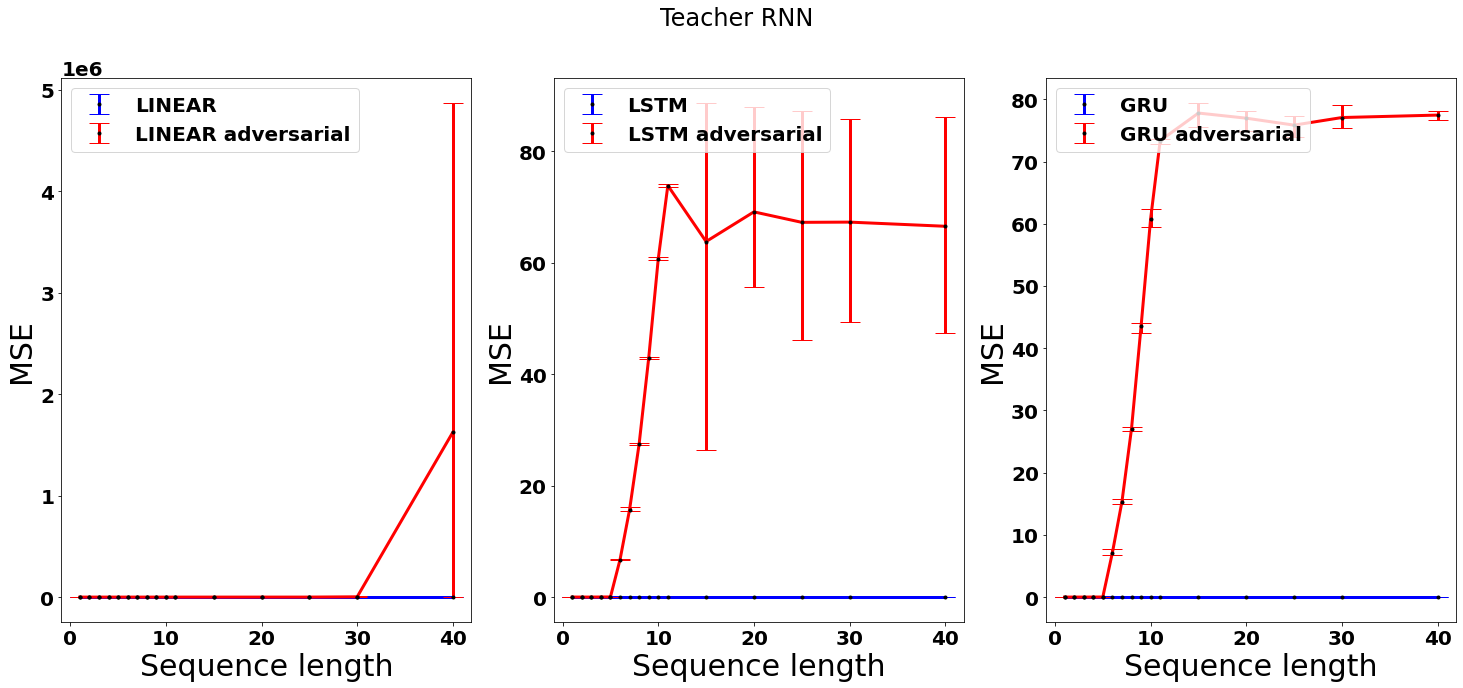

In [63]:
mse_or_accuracy_per_sequence_length_per_hidden_dim = {}
models = {}

for exp in range(NUM_EXPERIMENTS):
    print(f"we are on exp: {exp}")
    if exp not in mse_or_accuracy_per_sequence_length_per_hidden_dim.keys():
        mse_or_accuracy_per_sequence_length_per_hidden_dim[exp] = {}
    for config in configs:
        RANDOM_NORMAL_INIT = config["RANDOM_NORMAL_INIT"]
        A_INIT_TO_SYMETRIC = config["A_INIT_TO_SYMETRIC"]
        INIT_B_EQUAL_C = config["INIT_B_EQUAL_C"]
        is_lstm = config["is_lstm"]
        use_adversary = config["use_adversary"]
        GRU = config["GRU"]
        curr_seq_len = config["seq_len"]
        hidden_dim = config["hidden_dim"]
        # default_n_epocs_rnn = 300 if use_adversary else 100

        print(f"is_lstm: {is_lstm}")
        print(f"memory_less: {memory_less}")
        if is_lstm:
            print("GRU" if GRU else "LSTM")
        print(f"use_adversary: {use_adversary}")

        print(f"curr_seq_len {curr_seq_len} and hidden_dim {hidden_dim}")
        range_low_j_high_j = [hidden_dim]
        
        print(f"Experiment with learning rate: {lr}")


        if is_lstm:
            teacher_rnn, teacher_w, models = train_models()
            mse_or_accuracy_per_sequence_length = evaluate_models()
        else:
            mse_or_accuracy_per_sequence_length = handle_linear_rnn()

        mse_or_accuracy_per_sequence_length_per_hidden_dim[exp][(curr_seq_len, hidden_dim, memory_less, is_lstm, GRU, use_adversary)] = mse_or_accuracy_per_sequence_length

display_mse_results(mse_or_accuracy_per_sequence_length_per_hidden_dim)